In [137]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Input, Reshape
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

In [138]:
(x_train, _), (x_test, _) = mnist.load_data()

In [139]:
encoding_dim = 49
batch_size = 64
input_shape = 28, 28, 1

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

train_data = np.concatenate([x_train, x_test])

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print('Number of train samples:', train_data.shape[0])

Number of train samples: 70000


In [140]:
encoder_input = Input(shape=input_shape)

x = Flatten()(encoder_input)
encoder_output = Dense(encoding_dim, activation='relu')(x)

encoder = Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = Input(shape=(encoding_dim,))
x = Dense(28*28, activation='sigmoid')(decoder_input)
decoder_output = Reshape(input_shape)(x)

decoder = Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_38 (Dense)            (None, 49)                38465     
                                                                 
Total params: 38,465
Trainable params: 38,465
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 49)]              0         
                                                                 
 dense_39 (Dense)            (None, 78

In [141]:
autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 49)                38465     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         39200     
                                                                 
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [142]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [143]:
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', mode="auto"),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.0001, monitor='val_loss', mode='auto', verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='auto', verbose=1)
]

In [145]:
autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=50, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
750/750 [==============================] - ETA: 0s - loss: 0.0825
Epoch 1: val_loss improved from 0.08468 to 0.08248, saving model to best_model.h5
750/750 [==============================] - 4s 5ms/step - loss: 0.0825 - val_loss: 0.0825 - lr: 0.0010
Epoch 2/50
742/750 [============================>.] - ETA: 0s - loss: 0.0812
Epoch 2: val_loss improved from 0.08248 to 0.08154, saving model to best_model.h5
750/750 [==============================] - 4s 5ms/step - loss: 0.0812 - val_loss: 0.0815 - lr: 0.0010
Epoch 3/50
740/750 [============================>.] - ETA: 0s - loss: 0.0806
Epoch 3: val_loss improved from 0.08154 to 0.08110, saving model to best_model.h5
750/750 [==============================] - 5s 7ms/step - loss: 0.0806 - val_loss: 0.0811 - lr: 0.0010
Epoch 4/50
739/750 [============================>.] - ETA: 0s - loss: 0.0801
Epoch 4: val_loss improved from 0.08110 to 0.08078, saving model to best_model.h5
750/750 [==============================] - 4s 5ms/step - l

In [146]:
autoencoder.load_weights('best_model.h5')

In [147]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])

    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [148]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)

1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 52ms/step


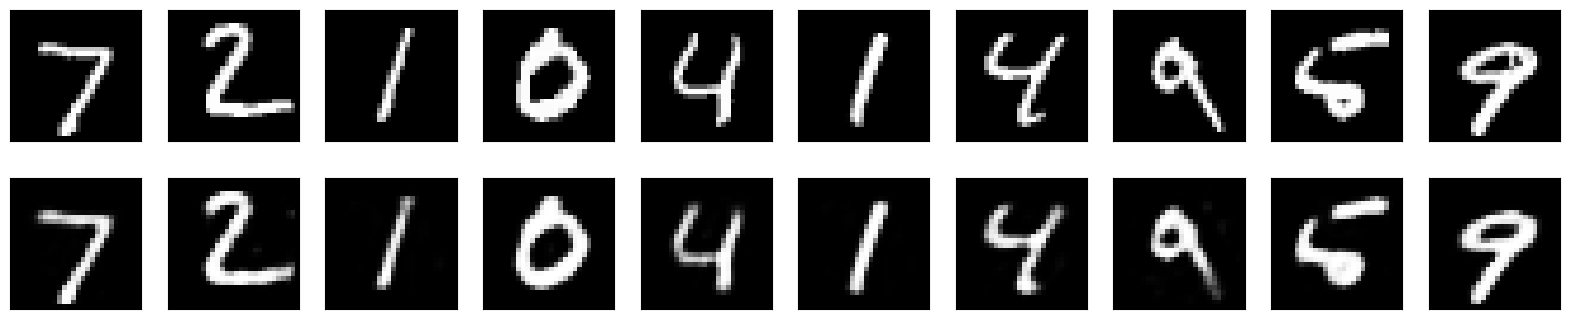

In [149]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)